In [1]:
import os
os.chdir("../LSTM")

In [2]:
from core.nn.LSTMmodel import LSTM

%load_ext autoreload
%autoreload 2

from SIR_ODE import SIR
import math
import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import requests, io, json, urllib
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle
import os.path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
from sklearn.metrics import mean_squared_error
from itertools import cycle

import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


In [4]:
def get_periods(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))
    

def plot_param(df, periods, TARGET):
    fig = px.line(df, x="Date", y=TARGET, title='Lockdown periods in ' + COUNTRY)
    for dates in periods:
        fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
    fig.show()

def add_bias(results, BIAS, isBias=True):
    data = results.copy()
    preds = []
    SIR_data = []
    dates = []
    x_dates, x_preds, total_dates = [], [], []
    x_plot_preds = []
    
    # START Adding bias after days_delay
    BIAS_START = DELAY_START + datetime.timedelta(days_delay)
    for date, pred, index in zip(data["valData"]["Date"], data["pred"], range(0, len(data["valData"]))):
        if date >= BIAS_START:
            preds.append(pred)
            dates.append(date)
            SIR_data.append(SIR_results["I"][index])
        x_dates.append(date)
        x_preds.append(pred)
        total_dates.append(date)
     # Add bias to prediction
    # Calculate trend in SIR-predictions
    x = np.arange(0,len(SIR_data))
    y = np.array(SIR_data)
    if len(y) > 1:
        z = np.polyfit(x, y, 1)[0]
    else:
        z = 1
        
    new_preds, old_preds = [], []
    weight = 3
    for i in range(len(preds)):
        if i == len(preds) - 1:
            diff = preds[i] - preds[i-1]
        else:
            diff = preds[i + 1] - preds[i]
        percent = (i+1) / days_delay
        weight += 0.1
        if isBias:
            new_trend = (percent * z/weight + diff)
            new_trend = new_trend + diff
            new_preds.append(preds[i] + new_trend)
        else:
            new_preds.append(preds[i])
        old_preds.append(preds[i])

    if len(y) <= 1:
        new_preds = data["pred"]
    combined_new_preds = new_preds
#     plt.plot(combined_new_preds)
#     plt.show()
    # Add data to results
    data["total_old_pred"] = data["pred"]
    data["pred"] = combined_new_preds
    data["oldpred"] = old_preds
    return data


Delay days: 11
2020-12-07 00:00:00
10175214 375422 0 9799792 0.016142204022773547 0.019569080873380783


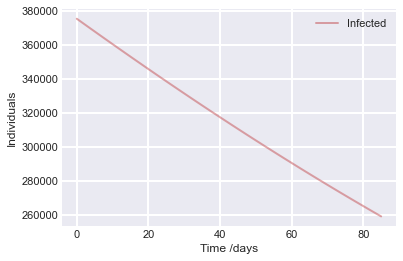

bias_res_Stringency_index_True_Sweden.p
RUN 0
RUN 1
RUN 2
RUN 3
100000000000.0
RUN 4
100000000000.0
RUN 5
4.616900444030762
RUN 6
RUN 7
100000000000.0
RUN 8
bias_res_Stringency_index_False_Sweden.p
RUN 0
11.362320899963379
RUN 1
RUN 2
100000000000.0
RUN 3
RUN 4
RUN 5
RUN 6
RUN 7
RUN 8
RUN 9
9.020524024963379
RUN 10
100000000000.0
RUN 11
1.627705693244934
RUN 12
RUN 13


KeyboardInterrupt: 

In [10]:
TARGET = "Stringency_index"
TARGET_NPI = TARGET
COUNTRIES =  ["Sweden", "United States"]

COUNTRIES = ["Italy", "United Kingdom", "Sweden", "United States", "Germany", "Netherlands", "India"]

for COUNTRY in COUNTRIES:
    NPI_df = oxcgrt_data.cleaned()
    NPI_df = NPI_df[NPI_df["Country"] == COUNTRY]

    # Get lockdown dates
    NPI_df = NPI_df.reset_index().drop('index', axis=1)
    NPI_df = NPI_df.groupby("Date").mean().reset_index()

    s = cs.Scenario(jhu_data, population_data, country=COUNTRY)
    days_delay, df_periods = s.estimate_delay(oxcgrt_data)
    print(f'Delay days: {days_delay}')

    NPI = TARGET_NPI
    NPI_dates = {}
    lockdown_indexes = NPI_df[NPI_df[NPI] >= 75].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= 75]["Date"]
    periods = get_periods(lockdown_indexes)

    if periods == []:
        lockdown_indexes = NPI_df[NPI_df[NPI] >= 65].index
        lockdown_dates = NPI_df[NPI_df[NPI] >= 65]["Date"]
        periods = get_periods(lockdown_indexes)

    if periods == []:
        lockdown_indexes = NPI_df[NPI_df[NPI] >= 4].index
        lockdown_dates = NPI_df[NPI_df[NPI] >= 4]["Date"]
        periods = get_periods(lockdown_indexes)

    if periods == []:
        lockdown_indexes = NPI_df[NPI_df[NPI] >= 3].index
        lockdown_dates = NPI_df[NPI_df[NPI] >= 3]["Date"]
        periods = get_periods(lockdown_indexes)

    lockdown_dates_adjusted = []
    for date in lockdown_dates:
        new_date = date + datetime.timedelta(days = days_delay)
        lockdown_dates_adjusted.append(new_date)
    NPI_dates[NPI] = lockdown_dates_adjusted

    lockdown_dates_adjusted = []
    for date in lockdown_dates:
        new_date = date + datetime.timedelta(days = days_delay)
        lockdown_dates_adjusted.append(new_date)
    lockdown_dates_adjusted = pd.Series(lockdown_dates_adjusted) 

    # Save variable DELAY_START, which is equal to the start of a lockdown period
    # in this case, we will hardcode the script to the second lockdown date
    # if len(periods) > 2:
    DELAY_START = NPI_df.iloc[periods[len(periods) - 1][0]].Date
    # else:
    #     DELAY_START = NPI_df.iloc[periods[0][0]].Date

    df = jhu_data.cleaned()
    df = df[(df["Country"] == COUNTRY) & (df["Province"] == "-")]
    df["New Confirmed"] = df["Confirmed"].diff()

    if COUNTRY == "United Kingdom":
        df_params = pd.read_pickle("df_United_Kingdom")
    elif COUNTRY == "Sweden":
        df_params = pd.read_pickle("../figures/pickles/df_Sweden")
    elif COUNTRY == "United States":
        df_params = pd.read_pickle("../figures/pickles/df_United_States")
    else:
        df_params = pd.read_pickle("../figures/pickles/df_9_countries")
    df_params["Country"].unique()
    df_params = df_params[df_params["Country"] == COUNTRY]

    TRAIN_UP_TO  = DELAY_START 
    print(DELAY_START)


    country_df = jhu_data.cleaned()
    country_df = country_df[(country_df["Country"] == COUNTRY) & (country_df["Province"] == "-") ]
    selection = country_df[country_df["Date"] == DELAY_START + datetime.timedelta(days_delay + 2)]

    selection["Confirmed"] = abs(selection["Confirmed"].values[0] - selection["Confirmed"].values[0])
    population_df = population_data.cleaned()
    N = population_df[population_df["Country"] == COUNTRY]["Population"].values[0]
    selection.head()

    target_column = "Confirmed"
    if selection["Confirmed"].values[0] == 0:
        target_column = "Infected"

    country_df = jhu_data.cleaned()
    country_df = country_df[(country_df["Country"] == COUNTRY) & (country_df["Province"] == "-") ]
    selection = country_df[country_df["Date"] == DELAY_START + datetime.timedelta(days_delay + 2)]

    def calc_param(df, lockdown_dates):
        total_params = ["theta", "kappa", "rho", "sigma"]
        calc_params_df = {}
        for param in total_params:
            values = []
            for date in df["Date"].values:
                if date in lockdown_dates.values:
                    values.append(np.mean(df[df['Date'] == date][param]))
            calc_params_df[param] = np.mean(values)
        return calc_params_df

    # params = calc_param(df_params, lockdown_dates_adjusted)
    params_total = {}
    sir_params_total = {}
    for p in NPI_dates:
        res = calc_param(df_params, pd.Series(NPI_dates[p]))
        if not math.isnan(res["kappa"]):
            params_total[p] = res

            sir = SIR(N=N, I0=selection[target_column].values[0], R0=selection["Recovered"].values[0], 
                      beta=res["rho"], gamma=res["theta"],
                     days=85)
            SIR_results = sir.simulate(target="Infected")
            sir_params_total[p] = SIR_results

    # -------------------------- LSTM -------------------------#
    DEVICE       = 'cpu'
    ThreshConf   = 70
    ThreshDead   = 20
    TARGET       = "New Confirmed"
    TYPE         = "LSTMCell"
    FUTURE_DAYS  = 5
    RUNS         = 5
    ERROR_THRESH = 1
    #     days_delay   = 16
    if TARGET_NPI != "Stringency_index":
        bias_bools   = [True]
    else:
        bias_bools = [True, False]

    BIAS = sir_params_total[TARGET_NPI]

    for WITH_BIAS in bias_bools:
        fname = f"bias_res_{TARGET_NPI}_{WITH_BIAS}_{COUNTRY}.p"
        print(fname)
        results_df = pd.DataFrame(columns=["Date"])

        # Check if dataframe already exists to build up on
        if os.path.isfile(fname):
            results_df = pickle.load(open( fname, "rb" ))
            j = len(results_df.columns)
            RUNS = j + RUNS
        else:
            j = 0

        while j < RUNS:
            print("RUN", j)
            FUTURE_DAYS  = 5
            lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START)
            results1 = lstm.simulate(ThreshConf=70)
            bias_results = add_bias(results1, BIAS)


            for i in range(4):
                FUTURE_DAYS += 6
                lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START)
                results2 = lstm.simulate(ThreshConf=70, input_data=bias_results)
                bias_results = add_bias(results2, BIAS, isBias=WITH_BIAS)

            trainData = pd.DataFrame(results2["trainData"])
            new_col = pd.DataFrame(trainData)
            new_col = new_col.set_index("Date")

            if j == 0:
                valDates = pd.Series(results2["valData"]["Date"])
                trainDates = pd.Series(results2["trainData"]["Date"])
                new_dates = trainDates.append(valDates)
                results_df["Date"] = new_dates
                results_df = results_df.set_index("Date")
                trueCases = results1["trainData"].set_index("Date")
                valCases = results1["valData"].set_index("Date")
                results_df["TrueCases"] = trueCases["ConfirmedCases"]
                results_df["valCases"] = valCases["ConfirmedCases"]

            error = results2["error"]

            # Don't save run if there were errors in prediction
            if error > ERROR_THRESH:
                print(error)
                RUNS += 1
            else:
                if j == 0:
                    results_df["ConfirmedCases"] = new_col["ConfirmedCases"]
                else:
                    new_col = new_col.rename(columns={"ConfirmedCases": "Cases" + str(j)})
                    results_df = pd.concat([results_df, new_col["Cases" + str(j)]], axis=1)
            j += 1

            if WITH_BIAS:
                results_df.to_pickle(fname)
            else:
                results_df.to_pickle(fname)


    